# News Features Generator #

Data set was generated on previous step

In [1]:
import numpy as np
import pandas as pd

rawData = pd.read_csv('partially_labeled_news.csv', sep='\t')

rawData.head(5)


,text,hate,aggressive
0,Print They should pay all the back all the mon...,0,NaN
1,Why Did Attorney General Loretta Lynch Plead T...,0,NaN
2,Red State : Fox News Sunday reported this morn...,0,NaN
3,Email Kayla Mueller was a prisoner and torture...,0,NaN
4,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,0,NaN


### Clear and encode text ###

In [2]:
import nltk
from nltk.stem import *
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

def textToTokens(text):
    sampleText = text.decode('utf-8').strip().lower()
    stop = stopwords.words('english')
    tokenizer = RegexpTokenizer(r'\w+')

    tokens = tokenizer.tokenize(sampleText)
    tags = nltk.pos_tag(tokens)

    def ineffitientToken(token):
        is_stopword = token[0] in stop
        is_number = token[1] == 'CD'
        return (is_stopword or is_number)
    
    return [t for t in tags if not ineffitientToken(t)]


### Translation from POS abbreviation to sentiwordnet abreviation ###

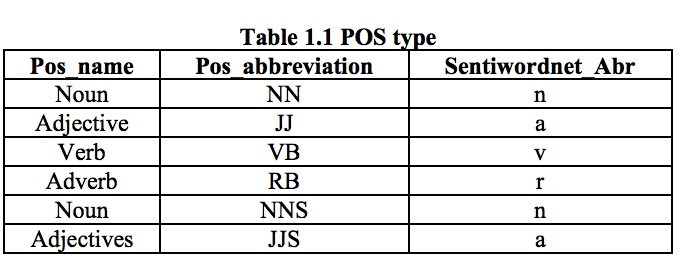

In [3]:
from IPython.display import Image
Image("img/positivity.png")

In [4]:
pos_type_map = { 'NN': 'n', 'JJ': 'a', 'VB': 'v', 'RB': 'r', 'NNS': 'n', 'JJS': 'a' }

In [5]:
def findFirstValidPOS(tag):
    feature = []
    if tag[1] in pos_type_map:
        feature = swn.senti_synsets(tag[0], pos_type_map[tag[1]])
    for pos in pos_type_map.values():
        if len(feature) > 0:
            return feature
        feature = swn.senti_synsets(tag[0], pos)
    return feature
    

In [6]:
def tagToResult(tag):
    return findFirstValidPOS(tag)

In [7]:
def sentiScore(tokens):
    not_analysed = []
    neg = 0.0; pos = 0.0; obj = 0.0; total = 0.0

    for token in tokens:
        analys = tagToResult(token)
        if len(analys) > 0:
            res = analys[0]
            total += 1
            neg += res.neg_score() * res.neg_score(); 
            pos += res.pos_score() * res.pos_score(); 
            obj += res.obj_score() * res.obj_score()
        else:
            not_analysed.append(token[0])
    if total == 0:
        return (0.0, 0.0, 0.0, 0.0)
    return ((neg / total), (pos / total), (obj / total), (len(not_analysed) / total))


# ADDITIONAL FEATURES #

## Emotions and judgmental search ##

Jujmental, 

frame (29): Mental_property
frame (219): Judgment_communication
frame (382): Contrition
frame (28): Judgment

Negative actions

frame (300): Predicament
frame (112): Cause_harm
frame (978): Losing_it
frame (12): Feigning

emotional words

frame ID=46 name=Emotion_directed
frame ID=47 name=Experiencer_obj>
frame (49): Emotion_heat
frame (48): Experiencer_focus
frame (2041): Cause_emotion
frame (2043): Emotions_success_or_failure
frame (45): Emotion_active
frame (2052): Fear
frame (2049): Annoyance

Words connected with politics

frame ID=73 name=Leadership
frame (72): Change_of_leadership
frame (1564): People_along_political_spectrum
frame (195): Political_locales

In [8]:
from nltk.corpus import framenet as fn

def idsToLexes(ids):
    lexs = {}
    for _id in ids:
        frame = fn.frame_by_id(_id)
        def lexDict(l):
            word, pos = l.split(".")
            return { word: pos}
        [lexs.update(lexDict(x)) for x in frame['lexUnit']]
    return lexs

In [9]:
judgmetal_lexes = idsToLexes([29, 219, 382, 28])
negative_lexes = idsToLexes([2049, 300, 112, 978, 12])
emo_lexes = idsToLexes([46, 47, 49, 48, 2041, 2043, 45, 2052, 2049])
politic_lexes = idsToLexes([73, 72, 1564, 195])

In [10]:
def countLexesMatches(lexes, tokens):
    matches = [t for t in tokens if t[0] in lexes ]
    return len(matches)

## Sentences Analysys ##

In [11]:
import re 

def emoSentencesPoints(text):
    def countExclamationMarks(text):
        return text.count('!')

    def findUpperCased(text):
        upperCasedWords = [w for w in text.split() if w.isupper()]
        return len(upperCasedWords)
    
    return countExclamationMarks(text) + findUpperCased(text)

def negations(text):
    result = re.findall(r"(n't\b)|(n’t\b)|(\bnothing\b)|(\bnever\b)|(\bno\b)|(\bnor\b)|(\bneither\b)|(\bnobody\b)|(\bnowhere\b)|(\bnowhere\b)|(\bnoone\b)|(\bnone\b)|(\bnot\b)", text)
    return len(result)
    

## Create Dataframe with all findings ##

In [12]:
def newsFeaturesRow(originalText):
    emo_text_points = emoSentencesPoints(originalText)
    negats = negations(originalText.lower())
    
    tokens = textToTokens(originalText)
    s_neg, s_pos, s_obj, unknown = sentiScore(tokens)
    judgment = countLexesMatches(judgmetal_lexes, tokens)
    emotions = countLexesMatches(emo_lexes, tokens)

    #print(unknown)
    return { "neg":  s_neg , 
              "pos":  s_pos , 
              "obj":  s_obj , 
              "judg":  judgment , 
              "emo":  emotions , 
              "emo_text_points":  emo_text_points , 
              "negations": negats }


In [13]:
#columns = [ "neg", "pos", "obj", "judg", "emo", "emo_text_points", "negations", "hate", "aggressive" ]
data = []
for text in rawData.text:
    data.append(newsFeaturesRow(text))
newsData = pd.DataFrame(data)
newsData.head(10)
#print(data)

,emo,emo_text_points,judg,neg,negations,obj,pos
0,2,4,0,0.016797,0,0.900781,0.002734
1,0,5,0,0.017617,1,0.865038,0.014786
2,0,2,0,0.018614,1,0.898641,0.007473
3,0,3,1,0.033203,1,0.786458,0.044922
4,1,9,0,0.017221,4,0.860215,0.026798
5,1,5,0,0.058520,0,0.794664,0.020342
6,0,31,1,0.027842,9,0.844425,0.027099
7,0,9,0,0.027715,4,0.864395,0.016403
8,1,10,0,0.017058,2,0.895929,0.015338
9,1,7,0,0.037671,3,0.831550,0.013485


In [14]:
newsData["hate"] = rawData["hate"]
newsData["aggressive"] = rawData["aggressive"]
print newsData.head(10)
print newsData["aggressive"].unique()

    emo  emo_text_points  judg       neg  negations       obj       pos  hate  \
0     2                4     0  0.016797          0  0.900781  0.002734     0   
1     0                5     0  0.017617          1  0.865038  0.014786     0   
2     0                2     0  0.018614          1  0.898641  0.007473     0   
3     0                3     1  0.033203          1  0.786458  0.044922     0   
4     1                9     0  0.017221          4  0.860215  0.026798     0   
5     1                5     0  0.058520          0  0.794664  0.020342     0   
6     0               31     1  0.027842          9  0.844425  0.027099     0   
7     0                9     0  0.027715          4  0.864395  0.016403     0   
8     1               10     0  0.017058          2  0.895929  0.015338     0   
9     1                7     0  0.037671          3  0.831550  0.013485     0   
10    3               41     1  0.018379         13  0.884265  0.016226     0   
11    3               10    

In [15]:
newsData.to_csv('news_featured.csv', sep='\t', index=False)